In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [ ]:
# Load dataset from Google Drive
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/dissertation/skin_care_hub_dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

Found 2056 files belonging to 8 classes.


In [ ]:
class_names = dataset.class_names
class_names

['black head',
 'flat wart',
 'haelthy skin',
 'keloid',
 'severe acne',
 'simple acne',
 'white head',
 'wrinkles']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 4 5 7 2 4 5 2 4 6 7 7 7 7 2 2 5 2 7 2 7 5 4 5 2 5 7 7 5 5 7 5]


# **Visualize some of the images from our dataset**

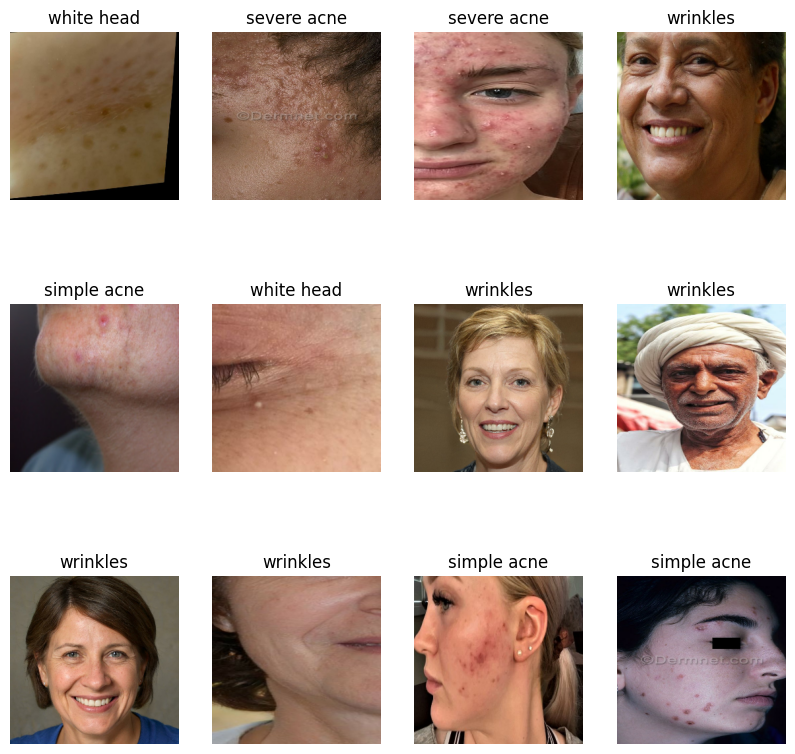

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# Function to Split Dataset
Dataset should be bifurcated into 3 subsets, namely:

*   Training: Dataset to be used while training
*   Validation: Dataset to be tested against while training
*   Test: Dataset to be tested against after we trained a model






In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=110):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
len(dataset)  #batches count

65

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
print('Train data batches',len(train_ds))
print('Validate data batches',len(val_ds))
print('Test data batches',len(test_ds))

Train data batches 45
Validate data batches 9
Test data batches 11


# Cache, Shuffle, and Prefetch the Dataset

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building the Model

Creating a Layer for Resizing and Normalization

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

***Data Augmentation***

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

***Applying Data Augmentation to Train Dataset***

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

**Model Architecture**


*   CNN coupled with a Softmax activation in the output layer
*    initial layers for resizing, normalization and Data Augmentation.



In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 8

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

# Compiling the Model
used adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [ ]:
print("Shape of train_ds: ",train_ds)

Shape of train_ds:  <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
history = model.fit(
    train_ds,
    epochs=65,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
)

Epoch 1/65
45/45 [==============================] - 13s 294ms/step - loss: 0.3846 - accuracy: 0.8630 - val_loss: 0.4056 - val_accuracy: 0.8542
Epoch 2/65
45/45 [==============================] - 13s 291ms/step - loss: 0.3664 - accuracy: 0.8750 - val_loss: 0.4080 - val_accuracy: 0.8681
Epoch 3/65
45/45 [==============================] - 13s 289ms/step - loss: 0.3897 - accuracy: 0.8566 - val_loss: 0.3301 - val_accuracy: 0.8958
Epoch 4/65
45/45 [==============================] - 13s 282ms/step - loss: 0.3518 - accuracy: 0.8743 - val_loss: 0.4636 - val_accuracy: 0.8472
Epoch 5/65
45/45 [==============================] - 13s 291ms/step - loss: 0.3956 - accuracy: 0.8510 - val_loss: 0.3893 - val_accuracy: 0.8854
Epoch 6/65
45/45 [==============================] - 13s 284ms/step - loss: 0.3608 - accuracy: 0.8630 - val_loss: 0.3908 - val_accuracy: 0.8924
Epoch 7/65
45/45 [==============================] - 13s 279ms/step - loss: 0.3144 - accuracy: 0.8948 - val_loss: 0.3955 - val_accuracy: 0.8715

In [ ]:
scores = model.evaluate(test_ds)

11/11 [==============================] - 10s 25ms/step - loss: 0.4409 - accuracy: 0.8445


In [ ]:
scores

[0.4409065246582031, 0.8445122241973877]

# Plotting the Accuracy and Loss Curves

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 45}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
type(history.history['loss'])

list

In [ ]:
len(history.history['loss'])

50

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.8102529048919678,
 1.7345887422561646,
 1.5302460193634033,
 1.3216229677200317,
 1.318339228630066]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

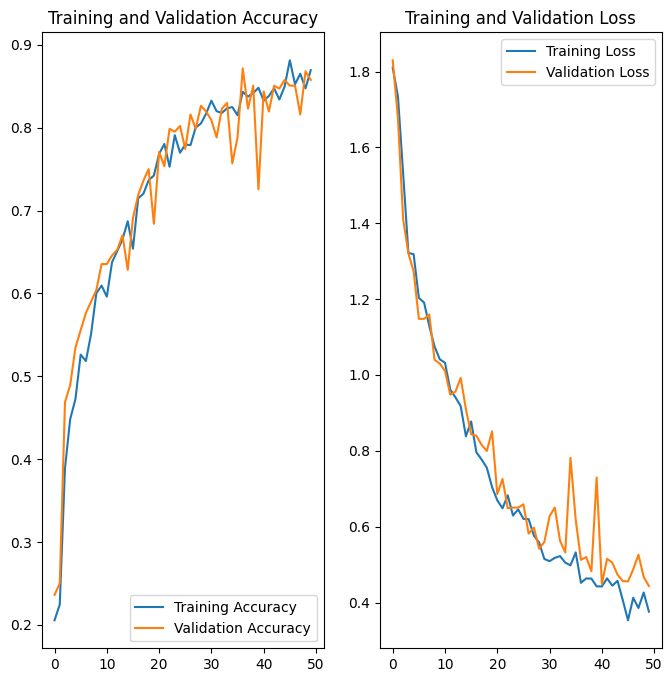

In [ ]:
# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(range(min(len(acc))), acc, label='Training Accuracy')
# plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(range(EPOCHS), loss, label='Training Loss')
# plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(min(len(acc), len(val_acc))), acc[:min(len(acc), len(val_acc))], label='Training Accuracy')
plt.plot(range(min(len(acc), len(val_acc))), val_acc[:min(len(acc), len(val_acc))], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(min(len(loss), len(val_loss))), loss[:min(len(loss), len(val_loss))], label='Training Loss')
plt.plot(range(min(len(loss), len(val_loss))), val_loss[:min(len(loss), len(val_loss))], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Run prediction on a sample image

first image to predict
actual label: severe acne
1/1 [==============================] - 0s 124ms/step
predicted label: severe acne
first image to predict
actual label: severe acne
1/1 [==============================] - 0s 30ms/step
predicted label: severe acne
first image to predict
actual label: haelthy skin
1/1 [==============================] - 0s 31ms/step
predicted label: haelthy skin
first image to predict
actual label: severe acne
1/1 [==============================] - 0s 31ms/step
predicted label: severe acne
first image to predict
actual label: haelthy skin
1/1 [==============================] - 0s 30ms/step
predicted label: haelthy skin
first image to predict
actual label: white head
1/1 [==============================] - 0s 35ms/step
predicted label: white head
first image to predict
actual label: severe acne
1/1 [==============================] - 0s 32ms/step
predicted label: severe acne
first image to predict
actual label: severe acne
1/1 [==============================] -

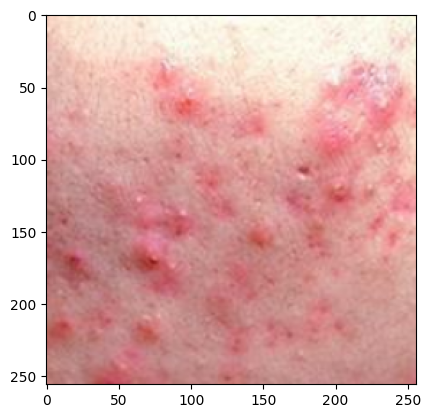

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(8):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

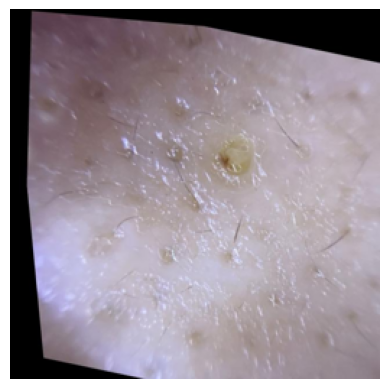

1/1 [==============================] - 0s 20ms/step
Predicted class: white head
Confidence: 100.0


In [ ]:
from PIL import Image
# Class names
class_names = ['black head',
 'flat wart',
 'haelthy skin',
 'keloid',
 'severe acne',
 'simple acne',
 'white head',
 'wrinkles']

def preprocess_image(image_path):
    image = np.array(
        Image.open(image_path).convert("RGB").resize((256, 256)) # image resizing
    )
    return image

# Path to your image
image_path = "/content/drive/MyDrive/dissertation/skin_care_hub_dataset/white head/cnt1089-3024x4032-341212131_jpg.rf.bb549f4d9a984651d322fb89da636995.jpg"
preprocessed_image = preprocess_image(image_path)

# Display the preprocessed image
import matplotlib.pyplot as plt
plt.imshow(preprocessed_image)
plt.axis('off')
plt.show()

# Make predictions
img_array = tf.expand_dims(preprocessed_image, 0)
predictions = model.predict(img_array)

# Get predicted class and confidence
predicted_class_index = np.argmax(predictions[0])
predicted_class = class_names[predicted_class_index]
confidence = round(100 * np.max(predictions[0]), 2)

print("Predicted class:", predicted_class)
print("Confidence:", confidence)


# Write a function for inference

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 28ms/step


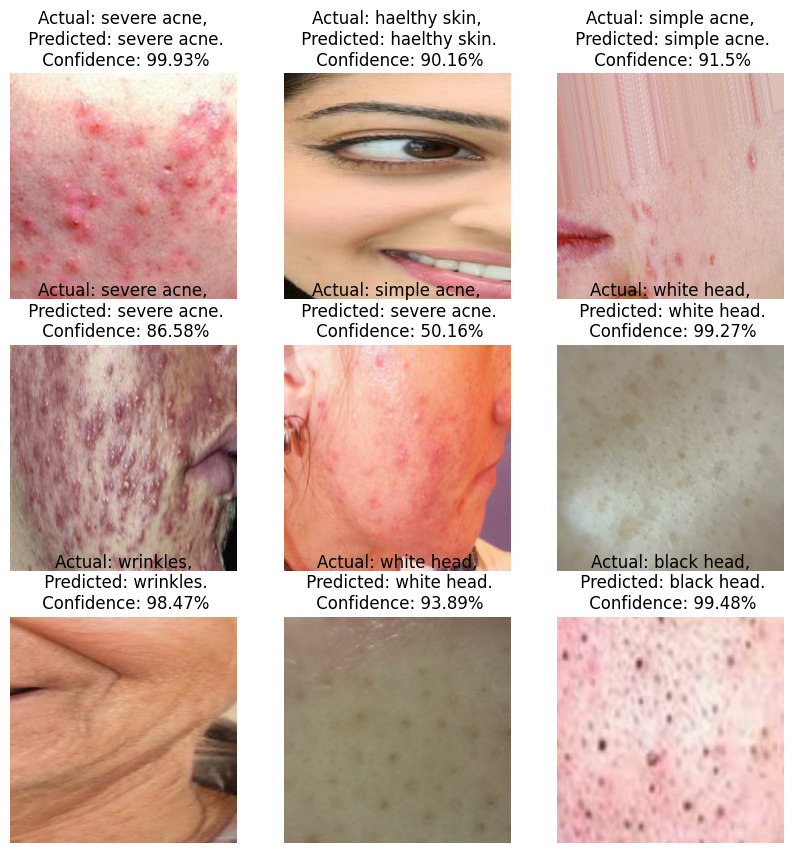

In [ ]:
#run inference on few sample images
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

# Saving the Model

In [ ]:
# import os
# model_version=max([int(i) for i in os.listdir("/content/drive/MyDrive/models") + [0]])+1
# model.save(f"/content/drive/MyDrive/models/{model_version}")

In [ ]:
model.save("/content/drive/MyDrive/models/skhub.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
